In [1]:
%cd ..
%pwd
import torch_geometric
import torch
import networkx as nx
from networkx import DiGraph
from typing import Optional, List, Any, Tuple
from torch_geometric.utils.convert import from_networkx
from heapq import heapify
import random
import torch.nn as nn

/home/tekne/Oxford/ATML/Project/ggs-nn-model


In [2]:
def parent(i: int) -> Optional[int]:
    if i <= 0:
        return None
    return (i - 1) // 2

def is_heap(l) -> bool:
    for (i, e) in enumerate(l):
        p = parent(i)
        if p is not None and l[p] > e:
            return False
    return True

In [3]:
TOKEN_DIM = 10

In [4]:
def make_array(token_dim: int = TOKEN_DIM, min_len: int = 1, max_len: int = 32, p_heapify: float = 0.4) -> Tuple[List[int], bool]:
    result = []
    for i in range(0, random.randint(min_len, max_len)):
        result.append(list(torch.randn(token_dim)))
    if random.random() < p_heapify: 
        heapify(result)
        result_is_heap = True
    else:
        result_is_heap = is_heap(result)
    return (torch.tensor(result), result_is_heap)

In [5]:
for i in range(0, 5):
    arr = make_array()
    print(f"Example {i} has shape {tuple(arr[0].shape)} and {'is' if arr[1] else 'is not'} a heap")

Example 0 has shape (23, 10) and is not a heap
Example 1 has shape (25, 10) and is not a heap
Example 2 has shape (29, 10) and is not a heap
Example 3 has shape (9, 10) and is not a heap
Example 4 has shape (13, 10) and is not a heap


In [6]:
def heapgraph(n: int) -> DiGraph:
    result = DiGraph()
    result.add_nodes_from(range(0, n))
    result.add_edges_from(
        (parent(i), i) for i in range(0, n) if parent(i) is not None
    )
    return result

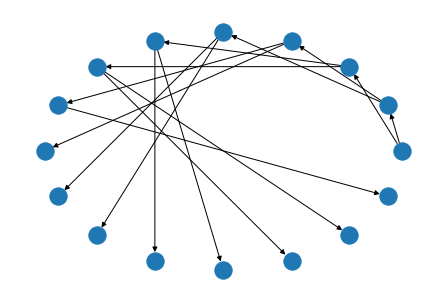

In [7]:
import matplotlib.pyplot as plt
nx.draw_circular(heapgraph(16))

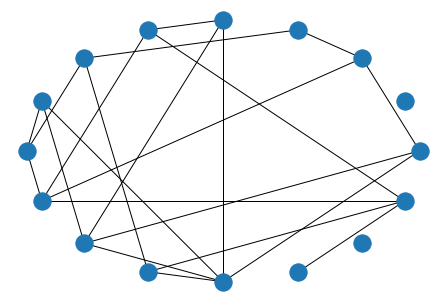

In [8]:
nx.draw_circular(nx.erdos_renyi_graph(16, 3/16))

In [9]:
def make_datapoint(token_dim: int = TOKEN_DIM, min_len: int = 1, max_len: int = 32, p_heapify: float = 0.4, p_heap_graph: float = 0.4) -> List[int]:
    (nodes, is_heap) = make_array(token_dim, min_len, max_len, p_heapify)
    n = nodes.shape[0]
    heapgraph_ = heapgraph(n)
    if random.random() < p_heap_graph: 
        graph = heapgraph_
        is_heapgraph = True
    else:
        graph = nx.erdos_renyi_graph(n, 3/(n + 1), directed=True)
        is_heapgraph = graph == heapgraph_
    
    data = from_networkx(graph)
    
    # Dumb edge case for when the number of edges is 0. Open an issue for torch_geometric?
    if data.edge_index.dtype != torch.long:
        data.edge_index = torch.zeros((2, 0), dtype=torch.long)

    assert data.edge_index.dtype == torch.long

    data.x = nodes
    data.y = torch.tensor([
        float(is_heap),
        float(is_heapgraph)
    ])

    return data

In [10]:
for i in range(0, 10):
    data = make_datapoint()
    print(f"Example {i}: {data} (y = {data.y})")

Example 0: Data(edge_index=[2, 84], x=[31, 10], y=[2]) (y = tensor([0., 0.]))
Example 1: Data(edge_index=[2, 23], x=[10, 10], y=[2]) (y = tensor([0., 0.]))
Example 2: Data(edge_index=[2, 56], x=[17, 10], y=[2]) (y = tensor([0., 0.]))
Example 3: Data(edge_index=[2, 0], x=[1, 10], y=[2]) (y = tensor([1., 0.]))
Example 4: Data(edge_index=[2, 65], x=[18, 10], y=[2]) (y = tensor([0., 0.]))
Example 5: Data(edge_index=[2, 12], x=[5, 10], y=[2]) (y = tensor([1., 0.]))
Example 6: Data(edge_index=[2, 82], x=[30, 10], y=[2]) (y = tensor([0., 0.]))
Example 7: Data(edge_index=[2, 28], x=[29, 10], y=[2]) (y = tensor([0., 1.]))
Example 8: Data(edge_index=[2, 9], x=[5, 10], y=[2]) (y = tensor([0., 0.]))
Example 9: Data(edge_index=[2, 85], x=[28, 10], y=[2]) (y = tensor([0., 0.]))


In [11]:
data = make_datapoint()

In [12]:
data.edge_index.dtype == torch.long

True

In [13]:
def generate_data(n: int, token_dim: int = TOKEN_DIM, min_len: int = 1, max_len: int = 32, p_heapify: float = 0.4):
    for _ in range(0, n):
        yield make_datapoint(token_dim, min_len, max_len, p_heapify)

In [14]:
list(generate_data(10))

[Data(edge_index=[2, 54], x=[20, 10], y=[2]),
 Data(edge_index=[2, 36], x=[13, 10], y=[2]),
 Data(edge_index=[2, 14], x=[8, 10], y=[2]),
 Data(edge_index=[2, 17], x=[18, 10], y=[2]),
 Data(edge_index=[2, 78], x=[27, 10], y=[2]),
 Data(edge_index=[2, 6], x=[7, 10], y=[2]),
 Data(edge_index=[2, 2], x=[3, 10], y=[2]),
 Data(edge_index=[2, 7], x=[8, 10], y=[2]),
 Data(edge_index=[2, 3], x=[4, 10], y=[2]),
 Data(edge_index=[2, 27], x=[11, 10], y=[2])]

In [15]:
training_data = torch_geometric.data.DataLoader(list(generate_data(10000)), batch_size=100)
testing_data = torch_geometric.data.DataLoader(list(generate_data(1000)), batch_size=100)

In [20]:
from ggnns.graph_level_ggnn import GraphLevelGGNN
from ggnns.cycle_data import *

ModuleNotFoundError: No module named 'global_soft_attention'

In [ ]:
HIDDEN_SIZE = 10

ggnn = GraphLevelGGNN(
    annotation_size=TOKEN_DIM,
    num_layers=3,
    gate_nn=nn.Linear(2*TOKEN_DIM + HIDDEN_SIZE, 1),
    hidden_size=HIDDEN_SIZE,
    final_layer=nn.Linear(2*TOKEN_DIM + HIDDEN_SIZE, 2)
).cuda()

In [ ]:
optimizer = torch.optim.Adam(ggnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [ ]:
ggnn.train()
epoch_losses = []
batch_losses = []
test_losses = []
for epoch in trange(0, 10):
    epoch_loss = 0.0
    count = 0
    for data in training_data:
        out = ggnn(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        loss = criterion(out.view(-1), data.y.cuda())
        loss.backward()
        batch_losses.append(float(loss))
        epoch_loss += float(loss)
        count += 1
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss /= count
    epoch_losses.append(epoch_loss)

    test_loss = 0.0
    count = 0
    for data in testing_data:
        out = ggnn(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        loss = criterion(out.view(-1), data.y.cuda())
        count += 1
        test_loss += float(loss)

    test_loss /= count
    test_losses.append(test_loss)

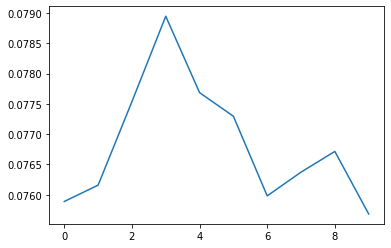

In [209]:
plt.plot(epoch_losses)

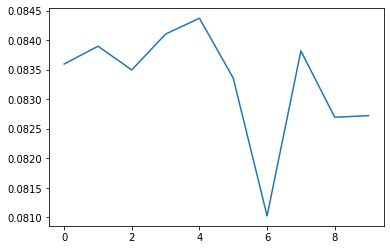

In [210]:
plt.plot(test_losses)

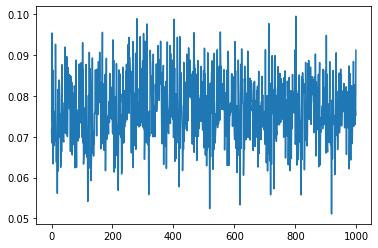

In [211]:
plt.plot(batch_losses)